# Random walk kernels experiments

### Imports

In [357]:
#GraKel patch
import ssl
from urllib.request import urlopen
from shutil import copyfileobj
from grakel.datasets import base as gk_base

def _download_zip_fixed(url, output_name):
    ctx = ssl.create_default_context(ssl.Purpose.SERVER_AUTH)
    filename = output_name + ".zip"
    data_url = urlopen(url, context=ctx)
    try:
        with open(filename, "w+b") as f:
            copyfileobj(data_url, f)
    finally:
        data_url.close()

gk_base._download_zip = _download_zip_fixed
gk_base.dataset_metadata["MUTAG"]["link"] = "https://www.chrsmrrs.com/graphkerneldatasets/MUTAG.zip"

In [358]:
from sage.all import *
import networkx as nx
import grakel as gk
from grakel.datasets import fetch_dataset
import numpy as np
from typing import Optional
import scipy.sparse as sp
import matplotlib.pyplot as plt

### Downloading Datasets

In [359]:

mutag = fetch_dataset("MUTAG", verbose=False, as_graphs=True)
mutag_graphs, y = mutag.data, mutag.target
print(len(mutag_graphs))

188


### Random Graph Generator

In [360]:
base_label = 23515

def nx_to_sage_graph(g) -> Graph:
    if not isinstance(g, (nx.Graph, nx.DiGraph, nx.MultiGraph, nx.MultiDiGraph)):
        raise TypeError("Not nx graph")
    sg = Graph()
    sg.add_vertices(list(g.nodes()))
    sg.add_edges([(u, v, base_label) for (u, v) in g.edges()])
    return sg
    

def graph_gen(kind: str, n: int, seed: Optional[int] = None) -> Graph:
    """
    er for Erdos-Renyi;
    ba for Barabasi-Albert;
    ws for Watts-Strogtz (small-world);
    sbm for Stochastic Block Model
    """
    if seed is None:
        seed = np.random.SeedSequence().entropy
    
    if kind == "er": #Erdos-Renyi
        #p = 2.0/n gives us a moderately sparse graph:
        #E[deg] ≈ (n - 1) * p ≈ 2
        return nx_to_sage_graph(nx.erdos_renyi_graph(n=n, p=float(2.0/n), seed=seed))
    
    if kind == "ba": #Barabasi-Albert (preferential attachment)
        # Each new node connects to m = max(1, n // 20) existing nodes.
        # This yields a scale-free graph with hubs.
        return nx_to_sage_graph(nx.barabasi_albert_graph(n=n, m=max(1, n // 20), seed=seed))
    
    if kind == "ws": #Watts-Strogtz (small-world)
        # Start with a ring where each node connects to k neighbors, then rewire edges with p = 0.1.
        # This keeps high clustering while creating short average paths.
        k = int(max(2, (n // 10) | 1))
        p = float(0.1)
        return nx_to_sage_graph(nx.watts_strogatz_graph(n=n, k=k, p=p, seed=seed))

    if kind == "sbm":
        # Stochastic Block Model with 2 groups.
        # Connect nodes within the same group with p_in = 0.15,
        # and across groups with p_out = 0.02 (weaker connections).
        sizes = [n//2, n - n//2]
        p_in, p_out = float(0.15), float(0.02)
        P = [
            [p_in,  p_out],
            [p_out, p_in]
        ]
        return nx_to_sage_graph(nx.stochastic_block_model(sizes, P, seed=seed))
    
    raise ValueError(f"unknown kind: {kind}")


### Visualising graph and adjacency matrix

In [361]:
def gk_to_sage_graph(gk_graph, undirected=True):
    A = gk_graph.get_adjacency_matrix()
    el = gk_graph.get_labels(label_type="edge", purpose="adjacency", return_none=True)
    n = A.shape[0]
    edges = []

    for i in range(n):
        for j in range(i + 1, n):
            if A[i, j] != 0:
                label = None if el is None else el.get((i, j), el.get((j, i)))
                if label is None:
                    edges.append((i, j, base_label))
                else:
                    edges.append((i, j, label))

    sg = Graph(edges, loops=False, multiedges=False)
    if not undirected:
        sg = sg.to_directed()
    return sg

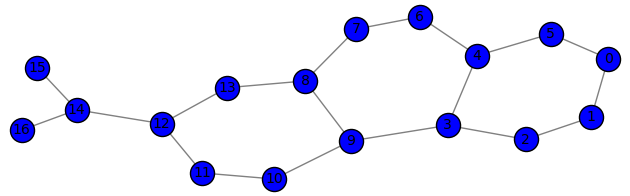

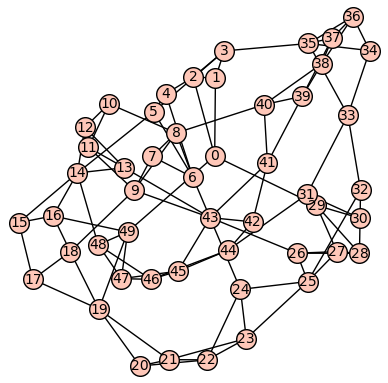

In [362]:
sg_mutag = gk_to_sage_graph(mutag_graphs[int(0)])
sg_mutag.plot(vertex_color="blue", edge_color="gray", vertex_size=300, layout="spring").show()

sg_ws = graph_gen("ws", int(50))
sg_ws.show()

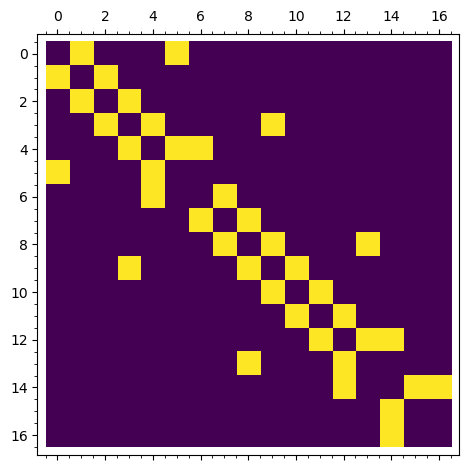

In [363]:
A_mutag = sg_mutag.adjacency_matrix()
matrix_plot(A_mutag, cmap='viridis')

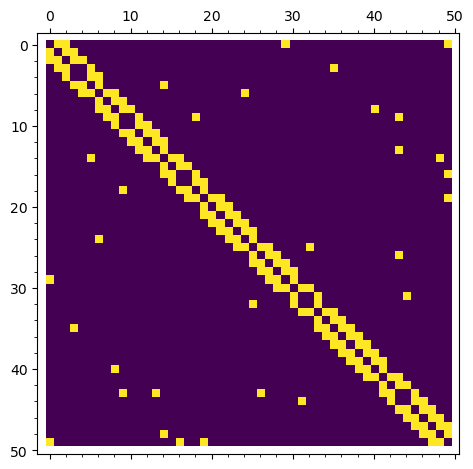

In [364]:
A_ws = sg_ws.adjacency_matrix()
matrix_plot(A_ws, cmap='viridis')

## Random Walk Kernels

We will implement Random-Walk Kernels computation based on [Fast Computation of Graph Kernels](https://proceedings.neurips.cc/paper_files/paper/2006/file/e37b08dd3015330dcbb5d6663667b8b8-Paper.pdf) by S.V.N. Vishwanathan, Karsten M. Borgwardt, Nicol N. Schraudolph

By defenitions $k(G, G') = q_x^T(I - \lambda * W_x)^{-1}p_x$, where $W_x = A \bigotimes A'$ (A - normalized adjacency matrix), $q_x = q \bigotimes q', p_x = p \bigotimes p'$

In [365]:
def labeled_norm_adj_mats(g, R=RDF, sparse=True):
    n = g.num_verts()
    deg = [g.degree([v])[0] for v in range(n)]
    inv_deg = [R(0) if d == 0 else R(1)/R(d) for d in deg]
    
    A = {}
    for u, v, label in g.edge_iterator(labels=True):
        label = base_label if label is None else label
        if label not in A:
            A[label] = matrix(R, n, n, sparse=sparse)
        A[label][u, v] = inv_deg[v]
        A[label][v, u] = inv_deg[u]
    return A


def rw_kernel_labeled(g1, g2, lmbd, p1, p2, q1, q2, R=RDF, sparse=True):
    n1, n2 = g1.num_verts(), g2.num_verts()
    N = n1 * n2
    p = vector(R, p1.tensor_product(p2).list())
    q = vector(R, q1.tensor_product(q2).list())

    A1 = labeled_norm_adj_mats(g1, R=R, sparse=sparse)
    A2 = labeled_norm_adj_mats(g2, R=R, sparse=sparse)

    W = zero_matrix(R, N, N, sparse=sparse)
    for label in set(A1) & set(A2):
        W += A1[label].tensor_product(A2[label])

    M = identity_matrix(R, N, sparse=sparse) - R(lmbd) * W
    x = M.solve_right(p) # (I - lmbd * W) x = p
    return float(q.dot_product(x)) # q^T * x

0.004836194522770777
0.0048361945227707774
0.006299757475677592


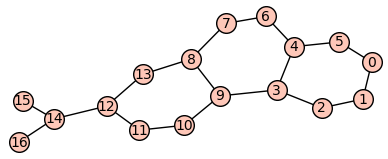

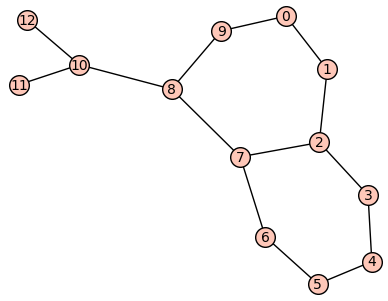

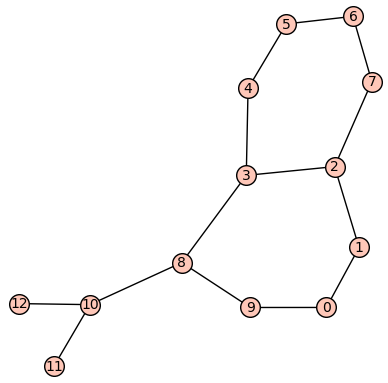

In [366]:
g1 = gk_to_sage_graph(mutag_graphs[int(0)])
g2 = gk_to_sage_graph(mutag_graphs[int(1)])
g3 = gk_to_sage_graph(mutag_graphs[int(2)])

n1 = int(g1.num_verts())
n2 = int(g2.num_verts())
n3 = int(g3.num_verts())

p1 = vector(RDF, [1 / n1] * n1)
q1 = vector(RDF, [1 / n1] * n1)

p2 = vector(RDF, [1 / n2] * n2)
q2 = vector(RDF, [1 / n2] * n2)

p3 = vector(RDF, [1 / n3] * n3)
q3 = vector(RDF, [1 / n3] * n3)

lmbd = float(0.1)

k12 = rw_kernel_labeled(g1, g2, lmbd, p1, p2, q1, q2)
print(k12)

k13 = rw_kernel_labeled(g1, g3, lmbd, p1, p3, q1, q3)
print(k13)

k23 = rw_kernel_labeled(g3, g2, lmbd, p3, p2, q3, q2)
print(k23)

g1.show()
g2.show()
g3.show()

### Efficient Computations

#### Sylvester Equasion Methods

#### Conjugate Gradient Methods

#### Fixed-Point Iterations

### Benchmark and Experiments